In [1]:
using Connectomes
using ADNIDatasets
using CSV, DataFrames
using DrWatson: projectdir
using Distributions
using Serialization
using DelimitedFiles
using MCMCChains
using CairoMakie

In [2]:
include(projectdir("functions.jl"))
include(projectdir("adni/inference/inference-preamble.jl"));

In [3]:

pst = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-taupos-4x2000.jls"));
pst2 = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-tauneg-4x2000.jls"));
pst3 = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-abneg-4x2000.jls"));

In [4]:
function get_diff(d)
    d[:,end] .- d[:,1]
end

get_diff (generic function with 1 method)

In [103]:
taupos_data = data[tau_pos]
taupos_suvr = calc_suvr.(taupos_data)
taupos_subdata = [normalise(sd, u0, cc) for sd in taupos_suvr]

taupos_vols = get_vol.(taupos_data)
taupos_total_vol_corrected = [v ./ sum(v, dims=1) for v in taupos_vols]
taupos_atr = [v ./ v[:,1] for v in taupos_total_vol_corrected];

In [104]:
tauneg_data = data[tau_neg]
tauneg_subsuvr = calc_suvr.(tau_neg_data)
_tauneg_subdata = [normalise(sd, u0, cc) for sd in tauneg_subsuvr];

blsd = [sd .- u0 for sd in _tauneg_subdata]
nonzerosubs = findall(x -> sum(x) < 2, [sum(sd, dims=1) .== 0 for sd in blsd])
tauneg_subdata = _tauneg_subdata[nonzerosubs];

tauneg_vols = get_vol.(tauneg_data)[nonzerosubs]
tauneg_total_vol_corrected = [v ./ sum(v, dims=1) for v in tauneg_vols]
tauneg_atr = [v ./ v[:,1] for v in tauneg_total_vol_corrected];

In [105]:
taupos_meanpst = mean(pst)
taupos_production = [taupos_meanpst["α[$i]", :mean] for i in 1:57]
taupos_transport  = [taupos_meanpst["ρ[$i]", :mean] for i in 1:57];

tauneg_meanpst = mean(pst2)
tauneg_production = [tauneg_meanpst["α[$i]", :mean] for i in 1:39]
tauneg_transport  = [tauneg_meanpst["ρ[$i]", :mean] for i in 1:39];

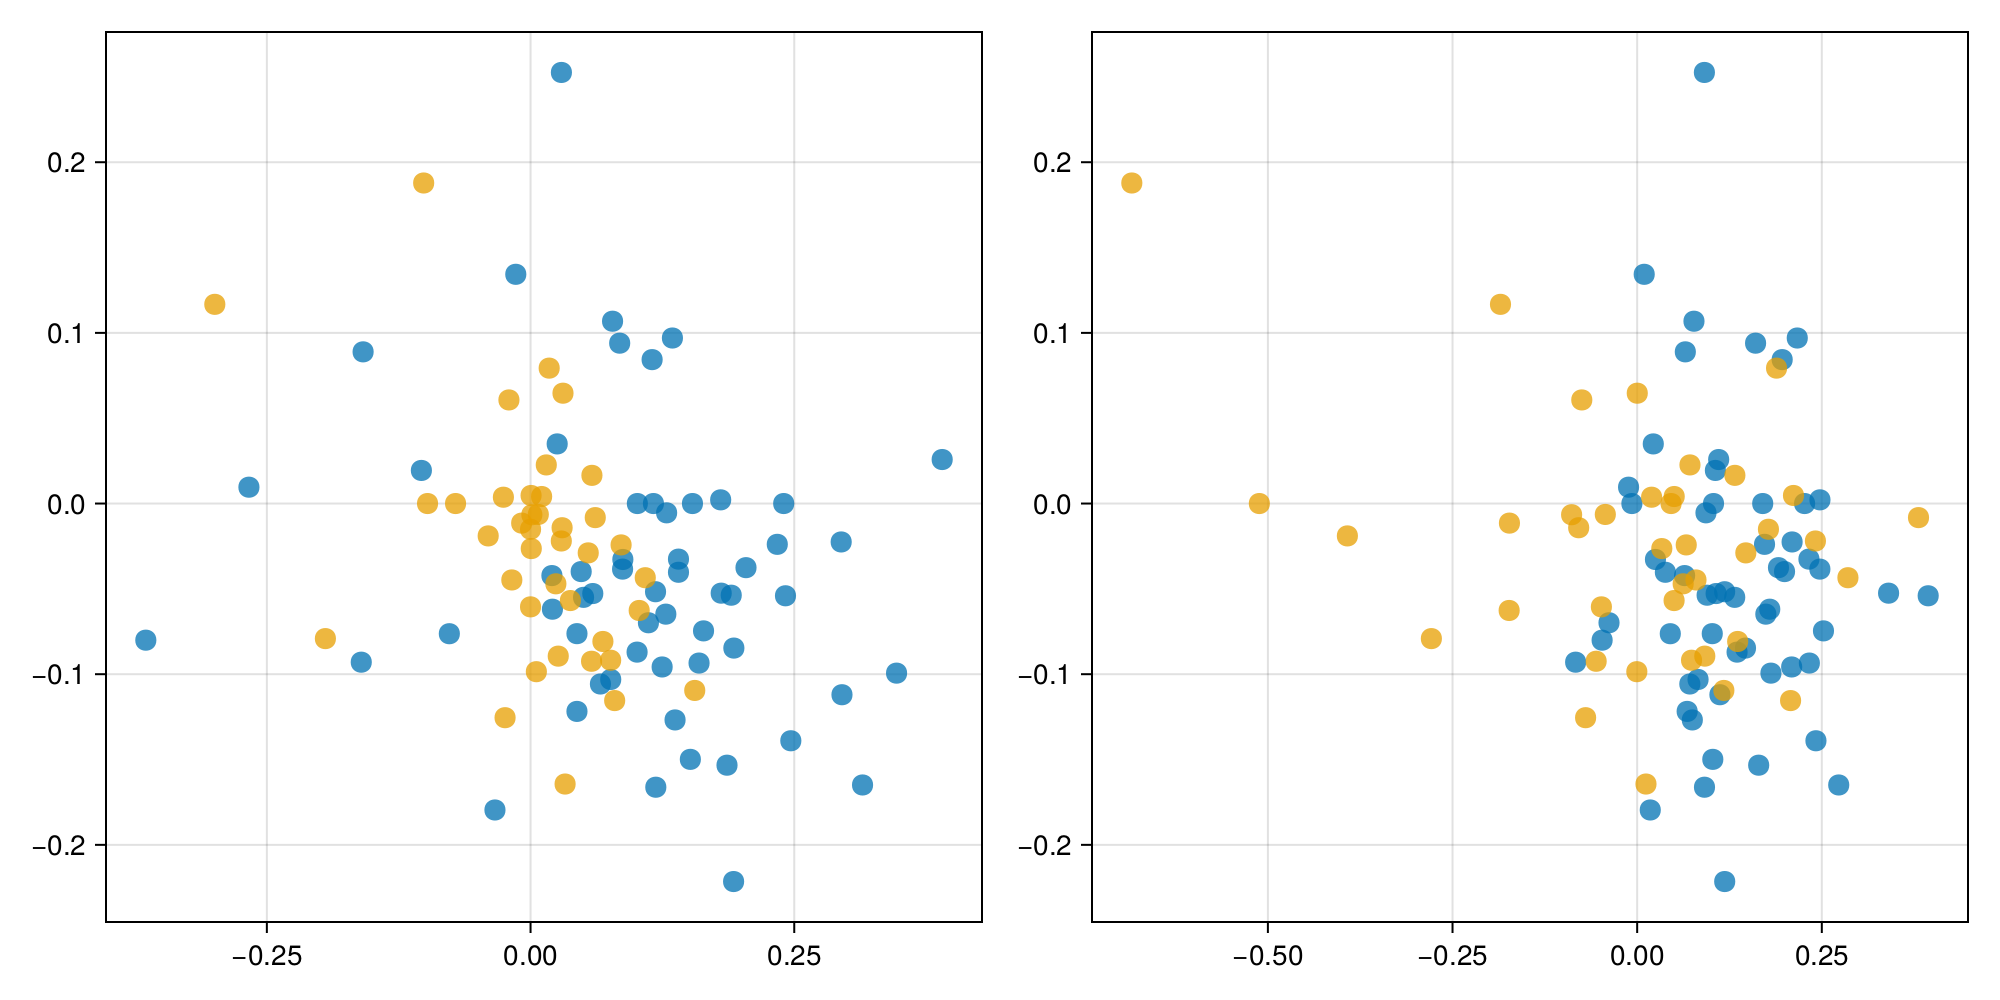

In [109]:
cols = Makie.wong_colors() 

taupos_total_initial_suvr = [sum(s, dims=1)[end] for s in taupos_subdata]
tauneg_total_initial_suvr = [sum(s, dims=1)[end] for s in tauneg_subdata]

taupos_suvr_diff = mean.([get_diff(sd[mtl,:]) for sd in taupos_subdata])
taupos_vol_diff = mean.([get_diff(sd[mtl,:]) for sd in taupos_atr])

tauneg_suvr_diff = mean.([get_diff(sd[mtl,:]) for sd in tauneg_subdata])
tauneg_vol_diff = mean.([get_diff(sd[mtl,:]) for sd in tauneg_atr])

begin
    f = Figure(size=(1000,500))
    ax = Axis(f[1,1])
    scatter!(taupos_suvr_diff, taupos_vol_diff, color=(cols[1], 0.75), markersize=15)
    scatter!(tauneg_suvr_diff, tauneg_vol_diff, color=(cols[2], 0.75), markersize=15)

    ax = Axis(f[1,2])
    scatter!(taupos_production, taupos_vol_diff, color=(cols[1], 0.75), markersize=15)
    scatter!(tauneg_production, tauneg_vol_diff, color=(cols[2], 0.75), markersize=15)

    f
end


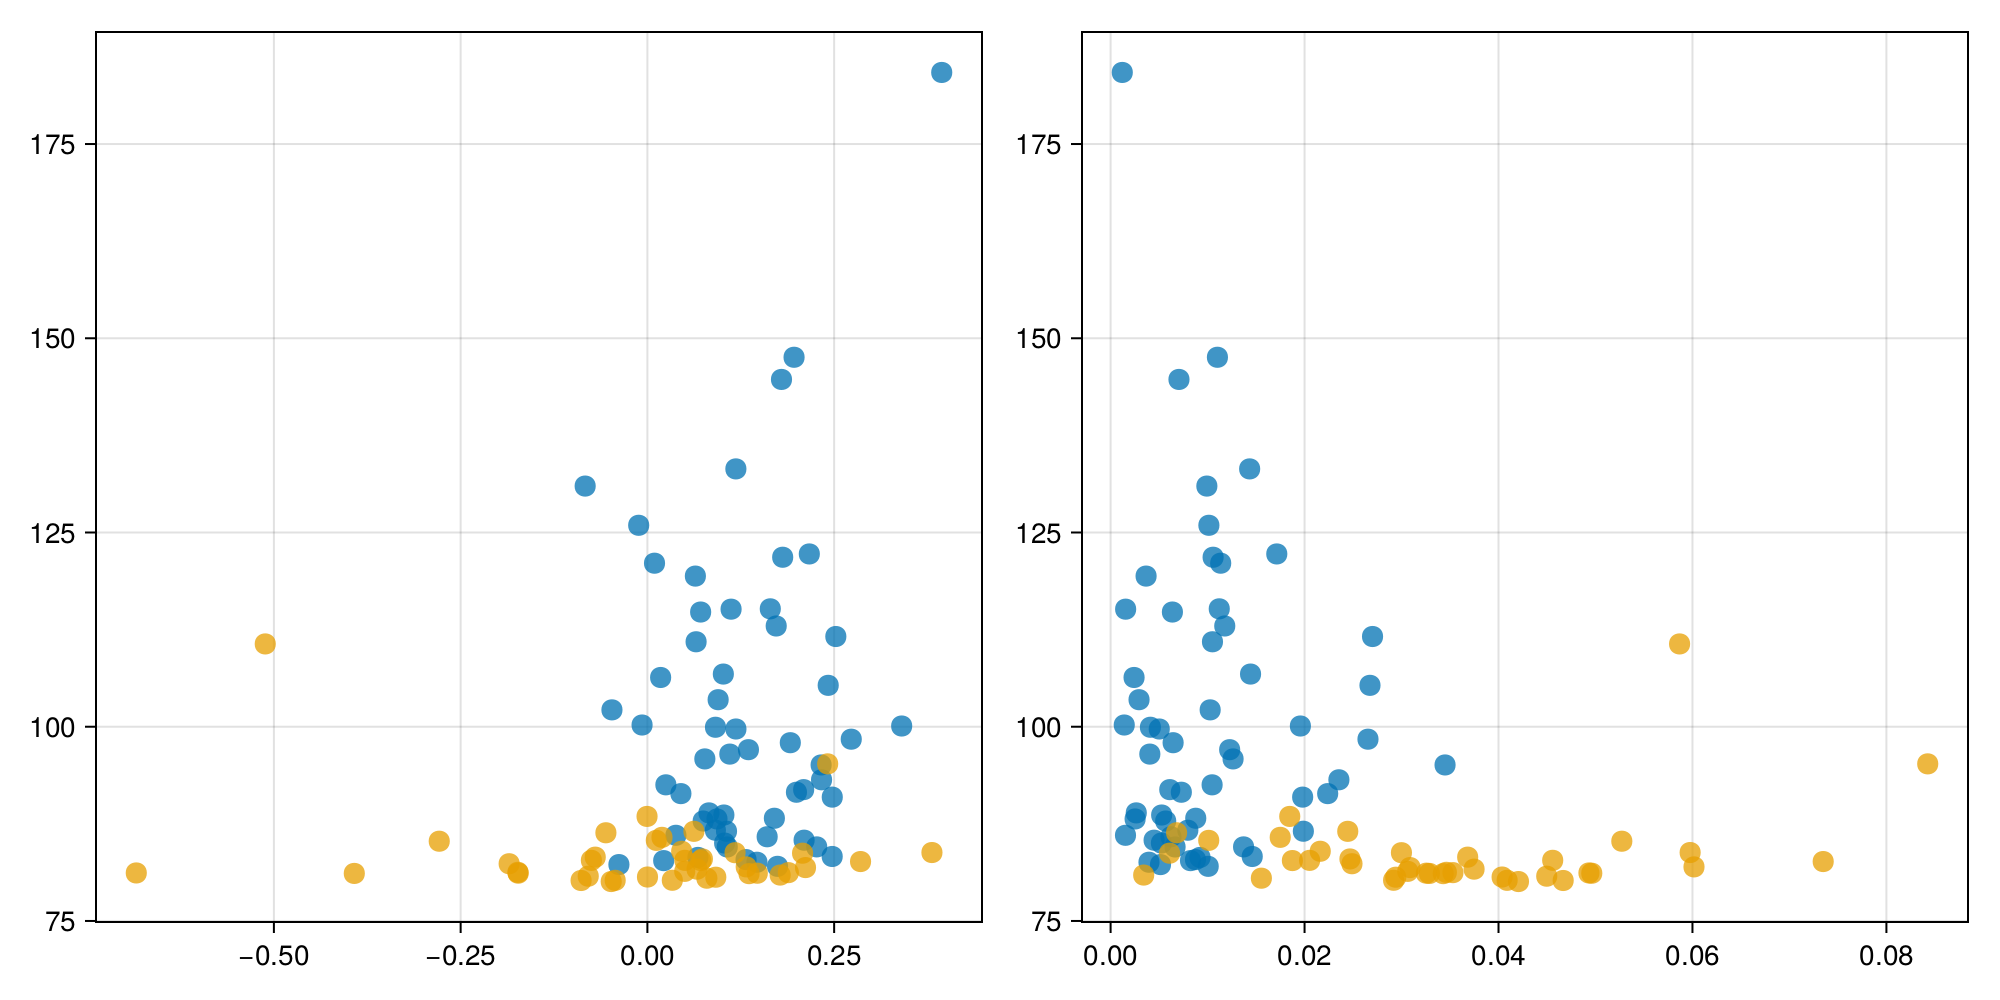

In [98]:
begin
    f = Figure(size=(1000,500))
    ax = Axis(f[1,1])
    scatter!(taupos_production, taupos_total_initial_suvr, color=(cols[1], 0.75), markersize=15)
    scatter!(tauneg_production, tauneg_total_initial_suvr, color=(cols[2], 0.75), markersize=15)
    ax = Axis(f[1,2])
    scatter!(taupos_transport, taupos_total_initial_suvr, color=(cols[1], 0.75), markersize=15)
    scatter!(tauneg_transport, tauneg_total_initial_suvr, color=(cols[2], 0.75), markersize=15)
    f
end